In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from arch import arch_model 
from tqdm import tqdm

# 0. Загрузка данных

In [2]:
# https://bonds.finam.ru/issue/details018F500002/default.asp -- пример источника данных

bonds_file_names = ['\SU26205RMFS3_rates.csv', 
                 '\SU26209RMFS5_rates.csv',
                 '\SU26212RMFS9_rates.csv',
                 '\SU26215RMFS2_rates.csv', 
                 '\SU26217RMFS8_rates.csv']

bonds_names = [x[1:len('SU26209RMFS5')+1] for x in bonds_file_names]

shares_file_names = ["\SBER.ME.csv", 
                  '\GAZP.ME.csv', 
                  '\YNDX.ME.csv',
                  '\MGNT.ME.csv', 
                  '\GMKN.ME.csv',
                  '\MTSS.ME.csv', 
                  '\PIKK.ME.csv', 
                  '\AFLT.ME.csv', 
                  '\POLY.ME.csv', 
                  '\RSTI.ME.csv']

shares_names = [x[1:5] for x in shares_file_names]

currencies_file_names = ['\D_USD.csv',
                      '\D_CNY.csv']

currencies_names = [x[3:6] for x in currencies_file_names]

risks_file_names = ['\IMOEX.ME.csv',
                    '\BZ=F.csv',
                    '\RTS.csv']   

risks_names = [x.split(chr(92))[1].split('.csv')[0] for x in risks_file_names]

bonds_folder = 'bonds'
shares_folder = 'shares'
currencies_folder = 'currencies'
risks_folder = 'risk_factors'

bonds = [bonds_folder + x for x in bonds_file_names]
shares = [shares_folder + x for x in shares_file_names]
currencies = [currencies_folder + x for x in currencies_file_names]
risks = [risks_folder + x for x in risks_file_names]
zero_bonds = risks_folder + '/zero_bonds.csv'
metals = risks_folder + '/refined_precious_metals.xlsx'

In [3]:
def load_df(bonds=bonds, bonds_names=bonds_names, 
            shares=shares, shares_names=shares_names,
            currencies=currencies, currencies_names=currencies_names,
            risks=risks, risks_names=risks_names,
            zero_bonds=zero_bonds, metals=metals):
#     Основной df
    main_df = pd.read_csv(bonds[0], index_col='<DATE>')
    main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
    main_df = main_df[[]]
    main_df.index.names = ['Date']
#     Загрузка облигаций
    for i in range(len(bonds)):
        df = pd.read_csv(bonds[i], index_col='<DATE>')
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        df = df[['<CLOSE>']].rename(columns={'<CLOSE>': bonds_names[i]})
        df.index.names = ['Date']
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка акций
    for i in range(len(shares)):
        df = pd.read_csv(shares[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': shares_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка валют
    for i in range(len(currencies)):
        df = pd.read_csv(currencies[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': currencies_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка рисков
    for i in range(len(risks)):
        df = pd.read_csv(risks[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка металлов
    df = pd.read_excel(metals, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Загрузка zero_bonds
    df = pd.read_csv(zero_bonds, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Заполнение пропусков
    main_df.fillna(method='ffill', inplace=True)
    main_df.fillna(method='backfill', inplace=True)

    return main_df

Портфель и риски в отдельных датафремах

In [4]:
prices = load_df()

bonds = prices.iloc[:, 0:5]
shares = prices.iloc[:, 5:15]
currencies = prices.iloc[:, 15:17]
risk_factors = prices.iloc[:, 17:]

ret = prices.pct_change()
ret.dropna(inplace=True)

bonds_ret = ret.iloc[:, 0:5]
shares_ret = ret.iloc[:, 5:15]
currencies_ret = ret.iloc[:, 15:17]
risk_factors_ret = ret.iloc[:, 17:]

# Составляем портфель

In [70]:
obligation_coupons_files = ['bonds\SU26205RMFS3.csv', 'bonds\SU26209RMFS5.csv', 'bonds\SU26212RMFS9.csv', 
                            'bonds\SU26215RMFS2.csv', 'bonds\SU26217RMFS8.csv']
def payment_per_day_bonds(obligation_coupons_files=obligation_coupons_files):

    obligation_coupons = []
    for i in range(len(obligation_coupons_files)):
        obligation_coupon = pd.read_csv(obligation_coupons_files[i])
        obligation_coupon.date = pd.to_datetime(obligation_coupon.date)
        days = (obligation_coupon[['date']].iloc[-2] \
                - obligation_coupon[['date']].iloc[-3]).values[0].astype('timedelta64[D]').astype(int)
        payment_per_day = obligation_coupon['payment'].iloc[-2] / days
        obligation_coupons.append(payment_per_day)

    return np.round(obligation_coupons, 5)

In [102]:
def calculate_portfolio_distribution(bonds=bonds, 
                                     shares=shares, 
                                     currencies=currencies):
    
    dirty_bonds = bonds + payment_per_day_bonds()
    df_for_portfolio = dirty_bonds.join((shares, currencies), how='left')
    
    position_0 = np.array([10e6] * 5 + [1e6] * 10 + [10e6] * 2)
    day_prices = df_for_portfolio.iloc[0] 
    true_qty = position_0 / day_prices
    qty = np.round(position_0 / day_prices, 0).astype(int)
    portfolio_qty_shares_true = (true_qty * day_prices) / (true_qty * day_prices).sum()
    
    all_qty = qty
    all_price = day_prices
    
    for t in range(1, df_for_portfolio.shape[0]):
        day_prices = df_for_portfolio.iloc[t-1]
        wts = (qty * day_prices) / np.sum(qty * day_prices)
        delta_wts = portfolio_qty_shares_true / wts
        qty = np.round(qty * delta_wts, 0).astype(int)
        all_qty = np.vstack((all_qty, qty))
        all_price = np.vstack((all_price, day_prices))
    
    number_of_assets = pd.DataFrame(all_qty, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    prices_of_assets = pd.DataFrame(all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    total_sum = pd.DataFrame(all_qty*all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    
    return number_of_assets, prices_of_assets, total_sum

In [103]:
number_of_assets, prices_of_assets, sum_portfolio = calculate_portfolio_distribution()

In [105]:
number_of_assets.to_csv('panama.csv', index=Fa)

In [89]:
total_sum

,SU26205RMFS3,SU26209RMFS5,SU26212RMFS9,SU26215RMFS2,SU26217RMFS8,SBER,GAZP,YNDX,MGNT,GMKN,MTSS,PIKK,AFLT,POLY,RSTI,USD,CNY
0,9.999995e+06,9.999985e+06,9.999966e+06,1.000005e+07,1.000001e+07,9.999548e+05,9.999424e+05,1.000246e+06,1.000197e+06,9.975757e+05,1.000027e+06,9.999310e+05,9.999374e+05,9.996933e+05,1.000000e+06,9.999989e+06,9.999999e+06
1,9.999699e+06,9.999689e+06,9.999691e+06,9.999669e+06,9.999712e+06,9.999548e+05,9.999424e+05,1.000246e+06,1.000197e+06,9.975757e+05,1.000027e+06,9.999310e+05,9.999374e+05,9.996933e+05,9.999686e+05,9.999683e+06,9.999691e+06
2,9.996329e+06,9.996336e+06,9.996366e+06,9.996339e+06,9.996370e+06,9.996598e+05,9.996056e+05,9.994400e+05,9.976027e+05,9.996008e+05,9.997099e+05,9.996513e+05,9.995957e+05,9.994833e+05,9.996360e+05,9.996368e+06,9.996351e+06
3,9.973018e+06,9.973020e+06,9.973000e+06,9.973011e+06,9.972973e+06,9.973288e+05,9.972452e+05,9.978440e+05,1.000270e+06,9.964904e+05,9.972191e+05,9.971822e+05,9.973455e+05,9.973153e+05,9.972982e+05,9.972962e+06,9.972983e+06
4,9.945517e+06,9.945516e+06,9.945545e+06,9.945546e+06,9.945548e+06,9.945684e+05,9.945077e+05,9.940700e+05,9.942148e+05,9.911925e+05,9.945873e+05,9.945176e+05,9.945809e+05,9.944850e+05,9.945544e+05,9.945543e+06,9.945542e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1.241331e+07,1.241331e+07,1.241329e+07,1.241336e+07,1.241331e+07,1.241220e+06,1.241396e+06,1.241244e+06,1.242241e+06,1.237020e+06,1.241449e+06,1.241170e+06,1.241309e+06,1.241219e+06,1.241334e+06,1.241335e+07,1.241334e+07
1004,1.236618e+07,1.236622e+07,1.236617e+07,1.236621e+07,1.236620e+07,1.236710e+06,1.236584e+06,1.235000e+06,1.238162e+06,1.231190e+06,1.236714e+06,1.236794e+06,1.236588e+06,1.237071e+06,1.236619e+06,1.236618e+07,1.236619e+07
1005,1.233878e+07,1.233874e+07,1.233875e+07,1.233874e+07,1.233876e+07,1.233851e+06,1.233787e+06,1.231712e+06,1.234243e+06,1.238186e+06,1.233846e+06,1.233874e+06,1.233875e+06,1.233646e+06,1.233878e+06,1.233880e+07,1.233877e+07
1006,1.235623e+07,1.235627e+07,1.235620e+07,1.235620e+07,1.235628e+07,1.235660e+06,1.235666e+06,1.233198e+06,1.233744e+06,1.229072e+06,1.235667e+06,1.235852e+06,1.235624e+06,1.235177e+06,1.235624e+06,1.235624e+07,1.235624e+07


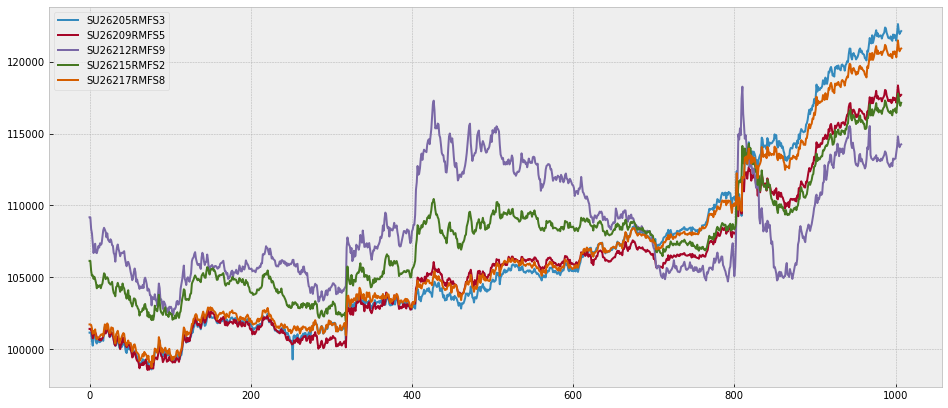

In [99]:
number_of_assets.iloc[:, :5].plot(figsize=(16, 7))

plt.show()